<a href="https://colab.research.google.com/github/yehaa2004/Naan-mudhalvan-projects/blob/main/USE_CASE_17_Time_Series_Forecasting_with_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F28865%2F36778%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240424%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240424T050112Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4e57ecb6b5e8c7fe977d4f73681f665745e22eab86afdf781db76463abae0fe5f408d1dcd9a05e63b9475ce421355ce9c15e4de27b5c8879b94e18f1ebfb7bb8562286ec1e21e781dc573af44d9ec471944b8f5d92eb20512bc049d1caff6be2301733749bde44368012aced6abf297603149542f7484c94a9e332fa4ae6fb7c84ea553230ee74958dbc3037f6fc02a5de9f1f06ce34d55339a4ad0ffb79c074114aa664fe249977fb52b79b2fdf213a71d1f3aa28a8a598da3501d54296e89335d88e8f431e019a61f6caf6c4ed5c35a342767dcfddaf2fd51510ffe61372d462c21491917c5137c10656a8a096c69513e69682b16b5ef2a41e3f9216f7802b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 586498 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


## Time Series Forecasting with Recurrent Neural Network (RNN)

### Abstract

* Purpose: to practice solving a timeseries problem by using Recurrent Neural Network

* Data: Bike Sharing in Washington D.C. Dataset

* Applied Tools & Methods: TimeSeriesGenerator, SimpleRNN

* Result: Around %80 correctness (calculated as 1-mae/mean)

* Further Studies: More advanced sequential methods like LSTM and GRU can be applied.

### Explanation of the Study

We have created a model to predict how many bicycles will be rented in the following days. The features used like weather, temperature, working day are explained in the following sections in detail.

We have used SimpleRNN method in Keras library. It is one of the sequential models. The others are LSTM and GRU.

Sequential models have 3 dimension (sample size, time steps, features). Preparing 3D input is another challenge. Instead of trying to create a 3D array, we use TimeSeriesGenerator class which brings some other advantages like setting the batch size.

We skipped feature engineering and visualization parts because main purpose was to practice a sequential neural network. It is possible to have better achivements by applying these methods and then create a predictive model.

Data is 2 years daily data. Number of samples is 731. We have splitted it into 631, 50, 50 as train, test and hold-out data respectively.

We have measured the performance of the model with ( 1 - (mean average error) / (mean) ) and we have reached values around %80.

There are so many further studies: More feature engineering for better accuracy and trying other sequential models.

### Importing Libraries

In [3]:
from keras import activations

In [6]:
pip install keras.activations

ERROR: Could not find a version that satisfies the requirement keras.activations (from versions: none)
ERROR: No matching distribution found for keras.activations


In [9]:
import pandas as pd;
import matplotlib.pyplot as plt
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RNN, SimpleRNN
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dropout
from keras.optimizers import Adam

from keras.callbacks import LambdaCallback
from sklearn.preprocessing import MinMaxScaler

### Data Preprocessing

#### Reading the dataset

In [10]:
import os
print(os.listdir("../input/bike-sharing-dataset"))
dataset = pd.read_csv('../input/bike-sharing-dataset/day.csv')

['day.csv', 'hour.csv', 'Readme.txt']


In [11]:
dataset.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


Daily data has the following fields. Thanks to the people who prepared it because it is very well processed data with even scaled features.

instant: Record index

dteday: Date

season: Season (1:springer, 2:summer, 3:fall, 4:winter)

yr: Year (0: 2011, 1:2012)

mnth: Month (1 to 12)

holiday: weather day is holiday or not (extracted from Holiday Schedule)

weekday: Day of the week

workingday: If day is neither weekend nor holiday is 1, otherwise is 0.

weathersit: (extracted from Freemeteo)
1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

temp: Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)

atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)

hum: Normalized humidity. The values are divided to 100 (max)

windspeed: Normalized wind speed. The values are divided to 67 (max)

casual: count of casual users

registered: count of registered users

cnt: count of total rental bikes including both casual and registered

#### Plot of 2 years number of sharing (cnt)

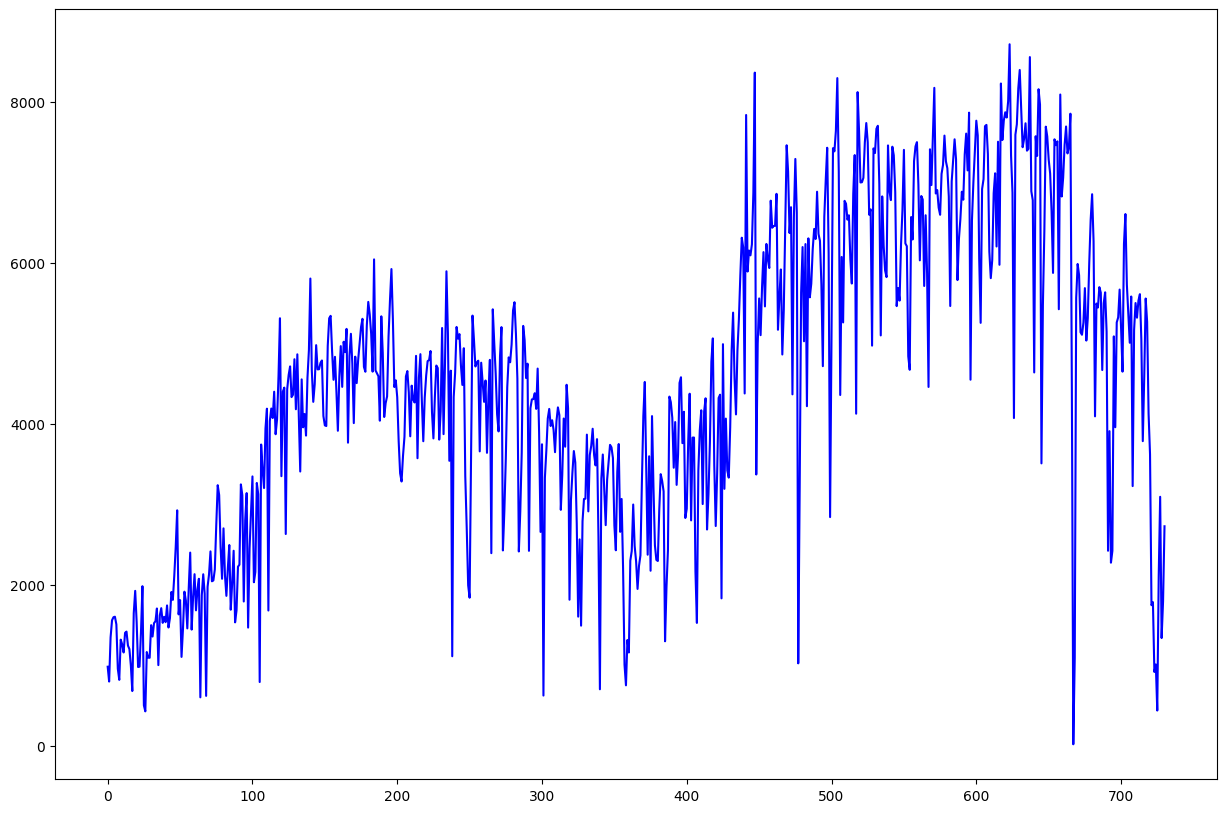

In [12]:
plt.figure(figsize=(15,10))
plt.plot(dataset['cnt'], color='blue')
plt.show()

#### Data exploration and Manipulation

* Number of bike sharing is 22 only at 2012-10-29 and such a low value deserves a special attention.

* There was a hurricane at Washington at that day.

* Since it is such an extraordinary day, hurricane and the following days data will be replaced by the average of that month.

In [13]:
temp = dataset[dataset.yr == 1]
temp = temp[temp.mnth == 10]
print(temp.cnt.mean())

6414.225806451613


In [14]:
temp.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
639,640,2012-10-01,4,1,10,0,1,1,2,0.520833,0.512000,0.649167,0.090804,763,6015,6778
640,641,2012-10-02,4,1,10,0,2,1,3,0.590833,0.542333,0.871667,0.104475,315,4324,4639
641,642,2012-10-03,4,1,10,0,3,1,2,0.657500,0.599133,0.793750,0.066546,728,6844,7572
642,643,2012-10-04,4,1,10,0,4,1,2,0.657500,0.607975,0.722917,0.117546,891,6437,7328
643,644,2012-10-05,4,1,10,0,5,1,1,0.615000,0.580187,0.627500,0.106350,1516,6640,8156


In [15]:
print(dataset['cnt'][667], dataset['cnt'][668])

22 1096


In [16]:
dataset['cnt'][667] = 6414
dataset['cnt'][668] = 6414

<ipython-input-16-27810ac100d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['cnt'][667] = 6414
<ipython-input-16-27810ac100d6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['cnt'][668] = 6414


#### One Hot Encoding

We should apply one hot encoding for categorical features. In our case weekday, weathersit and mnth features are one hot encoded.

In [17]:
one_hot = pd.get_dummies(dataset['weekday'], prefix='weekday')
dataset = dataset.join(one_hot)

In [18]:
one_hot = pd.get_dummies(dataset['weathersit'], prefix='weathersit')
dataset = dataset.join(one_hot)

In [19]:
one_hot = pd.get_dummies(dataset['mnth'], prefix='mnth')
dataset = dataset.join(one_hot)

#### Scaling

Thanks to the guys prepared the original data, they scaled all features. That is why we have to apply it only for our value Y which is cnt. It is also a discussion whether Y value should be scaled or not in sucha model but we did.

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(array(dataset['cnt']).reshape(len(dataset['cnt']), 1))
series = pd.DataFrame(scaled)
series.columns = ['cntscl']

In [21]:
dataset = pd.merge(dataset, series, left_index=True, right_index=True)

In [22]:
dataset.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,...,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,cntscl
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,...,False,False,False,False,False,False,False,False,False,0.066884
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,...,False,False,False,False,False,False,False,False,False,0.044670
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,...,False,False,False,False,False,False,False,False,False,0.110829
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,...,False,False,False,False,False,False,False,False,False,0.136545
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,...,False,False,False,False,False,False,False,False,False,0.141132


#### Data Splitting

In [23]:
number_of_test_data = 50
number_of_holdout_data = 50
number_of_training_data = len(dataset) - number_of_holdout_data - number_of_test_data
print ("total, train, test, holdout:", len(dataset), number_of_training_data, number_of_test_data, number_of_holdout_data)

total, train, test, holdout: 731 631 50 50


In [24]:
datatrain = dataset[:number_of_training_data]
datatest = dataset[-(number_of_test_data+number_of_holdout_data):-number_of_holdout_data]
datahold = dataset[-number_of_holdout_data:]

### Preparing 3-Dimensional Input for Sequential Model

The following steps show the way how to prepare input for a sequential model by using TimeSeriesGenerator.

In [25]:
in_seq1 = array(datatrain['holiday'])
in_seq2 = array(datatrain['workingday'])
in_seq3 = array(datatrain['temp'])
in_seq4 = array(datatrain['atemp'])
in_seq5 = array(datatrain['hum'])
in_seq6 = array(datatrain['windspeed'])
in_seq7 = array(datatrain['weekday_0'])
in_seq8 = array(datatrain['weekday_1'])
in_seq9 = array(datatrain['weekday_2'])
in_seq10 = array(datatrain['weekday_3'])
in_seq11 = array(datatrain['weekday_4'])
in_seq12 = array(datatrain['weekday_5'])
in_seq13 = array(datatrain['weekday_6'])
in_seq14 = array(datatrain['weathersit_1'])
in_seq15 = array(datatrain['weathersit_2'])
in_seq16 = array(datatrain['weathersit_3'])
out_seq_train = array(datatrain['cntscl'])

In [26]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
in_seq10 = in_seq10.reshape((len(in_seq10), 1))
in_seq11 = in_seq11.reshape((len(in_seq11), 1))
in_seq12 = in_seq12.reshape((len(in_seq12), 1))
in_seq13 = in_seq13.reshape((len(in_seq13), 1))
in_seq14 = in_seq14.reshape((len(in_seq14), 1))
in_seq15 = in_seq15.reshape((len(in_seq15), 1))
in_seq16 = in_seq16.reshape((len(in_seq16), 1))
out_seq_train = out_seq_train.reshape((len(out_seq_train), 1))

In [27]:
datatrain_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, in_seq11, in_seq12, in_seq13, in_seq14, in_seq15, in_seq16, out_seq_train))

In [28]:
in_seq1 = array(datatest['holiday'])
in_seq2 = array(datatest['workingday'])
in_seq3 = array(datatest['temp'])
in_seq4 = array(datatest['atemp'])
in_seq5 = array(datatest['hum'])
in_seq6 = array(datatest['windspeed'])
in_seq7 = array(datatest['weekday_0'])
in_seq8 = array(datatest['weekday_1'])
in_seq9 = array(datatest['weekday_2'])
in_seq10 = array(datatest['weekday_3'])
in_seq11 = array(datatest['weekday_4'])
in_seq12 = array(datatest['weekday_5'])
in_seq13 = array(datatest['weekday_6'])
in_seq14 = array(datatest['weathersit_1'])
in_seq15 = array(datatest['weathersit_2'])
in_seq16 = array(datatest['weathersit_3'])
out_seq_test = array(datatest['cntscl'])

In [29]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
in_seq10 = in_seq10.reshape((len(in_seq10), 1))
in_seq11 = in_seq11.reshape((len(in_seq11), 1))
in_seq12 = in_seq12.reshape((len(in_seq12), 1))
in_seq13 = in_seq13.reshape((len(in_seq13), 1))
in_seq14 = in_seq14.reshape((len(in_seq14), 1))
in_seq15 = in_seq15.reshape((len(in_seq15), 1))
in_seq16 = in_seq16.reshape((len(in_seq16), 1))
out_seq_test = out_seq_test.reshape((len(out_seq_test), 1))

In [30]:
datatest_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, in_seq11, in_seq12, in_seq13, in_seq14, in_seq15, in_seq16, out_seq_test))

In [31]:
in_seq1 = array(datahold['holiday'])
in_seq2 = array(datahold['workingday'])
in_seq3 = array(datahold['temp'])
in_seq4 = array(datahold['atemp'])
in_seq5 = array(datahold['hum'])
in_seq6 = array(datahold['windspeed'])
in_seq7 = array(datahold['weekday_0'])
in_seq8 = array(datahold['weekday_1'])
in_seq9 = array(datahold['weekday_2'])
in_seq10 = array(datahold['weekday_3'])
in_seq11 = array(datahold['weekday_4'])
in_seq12 = array(datahold['weekday_5'])
in_seq13 = array(datahold['weekday_6'])
in_seq14 = array(datahold['weathersit_1'])
in_seq15 = array(datahold['weathersit_2'])
in_seq16 = array(datahold['weathersit_3'])
out_seq_hold = array(datahold['cntscl'])

In [32]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
in_seq10 = in_seq10.reshape((len(in_seq10), 1))
in_seq11 = in_seq11.reshape((len(in_seq11), 1))
in_seq12 = in_seq12.reshape((len(in_seq12), 1))
in_seq13 = in_seq13.reshape((len(in_seq13), 1))
in_seq14 = in_seq14.reshape((len(in_seq14), 1))
in_seq15 = in_seq15.reshape((len(in_seq15), 1))
in_seq16 = in_seq16.reshape((len(in_seq16), 1))
out_seq_hold = out_seq_hold.reshape((len(out_seq_hold), 1))

In [33]:
datahold_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, in_seq11, in_seq12, in_seq13, in_seq14, in_seq15, in_seq16, out_seq_hold))

In [34]:
n_features = datatrain_feed.shape[1]
n_input = 10
generator_train = TimeseriesGenerator(datatrain_feed, out_seq_train, length=n_input, batch_size=len(datatrain_feed))

In [35]:
generator_test = TimeseriesGenerator(datatest_feed, out_seq_test, length=n_input, batch_size=1)

In [36]:
generator_hold = TimeseriesGenerator(datahold_feed, out_seq_hold, length=n_input, batch_size=1)

### Modelling and Training

We have created a small RNN with 4 nodes.
Number of total parameters in the model is 93.
Number of timesteps in one batch is 10.
Activation function is relu both for RNN and Output layer.
Optimizer is adam.
Loss function is mean squared error.
Learning rate is 0.0001.
Number of epocs is 3,000.

#### Creating the SimpleRNN Model

In [37]:
print("timesteps, features:", n_input, n_features)

timesteps, features: 10 17


In [38]:
model = Sequential()

model.add(SimpleRNN(4, activation='relu', input_shape=(n_input, n_features), return_sequences = False))
model.add(Dense(1, activation='relu'))

adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss='mse')

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 4)                 88        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 93 (372.00 Byte)
Trainable params: 93 (372.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Training the Model

In [40]:
score = model.fit_generator(generator_train, epochs=3000, verbose=0, validation_data=generator_test)

<ipython-input-40-c3d0214c80a8>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  score = model.fit_generator(generator_train, epochs=3000, verbose=0, validation_data=generator_test)


#### Plot of Test Loss Functions

PREDICTION

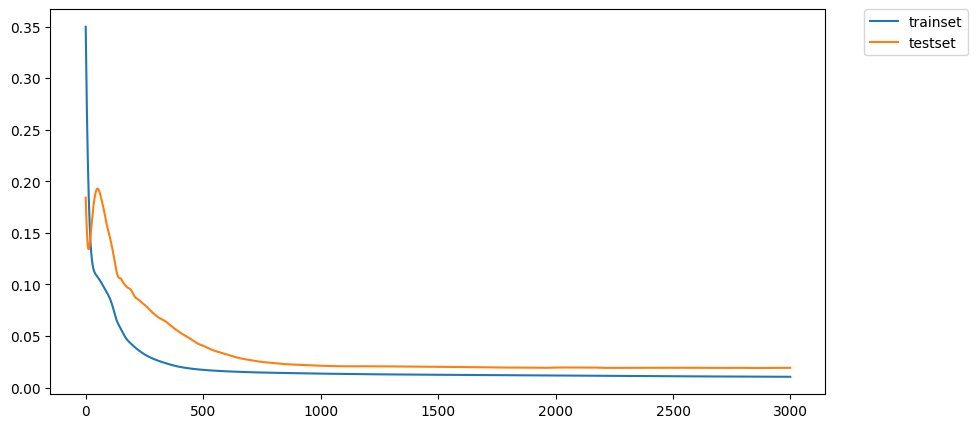

In [41]:
losses = score.history['loss']
val_losses = score.history['val_loss']
plt.figure(figsize=(10,5))
plt.plot(losses, label="trainset")
plt.plot(val_losses, label="testset")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()